In [1]:
#Basic imports
%matplotlib inline
import importlib 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from numba import cuda
import warnings

# Data Processing

In [2]:
# Import data
#data = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)
data = pd.read_excel('data2.xlsx', 'Sheet1', header=0)

In [3]:
data['Date of birth'] = pd.to_datetime(data['Date of birth'].astype(str), format='%d/%m/%Y')
data['Date of MRI scan'] = pd.to_datetime(data['Date of MRI scan'].astype(str), format='%Y-%m-%d', errors='ignore')
data['Age'] = (data['Date of MRI scan'] - data['Date of birth'])/ np.timedelta64(1, 'Y')

In [4]:
def clean_data(df, del_col=[], mean=[], std=[]):
    X = df.copy()
    
    # Remove useless columns
    X = X.drop(['Subject ID', 'Date of birth', 'Date of MRI scan'], axis=1)
    #X = X.drop(['Patient ID', 'Batch Process ID'], axis=1)
    
    # Remove columns with only zeros
    if (len(del_col) == 0):
        del_col = (X != 0).any(axis=0)
    X = X.loc[:, del_col]
    
    # Replace zeros by nan
    X.replace(0, np.nan, inplace=True)
    
    # Replace Sex labels by values
    #X['Sex'].replace({'Male':1,'Female':2}, inplace=True)
    
    # Categorical values
    cater = X[['Gender']]
    #cater = X[['Sex']]
    
    # Numerical values
    numer = X.drop(['Gender'], axis=1)
    #numer = X.drop(['Sex'], axis=1)
    
    # Replace nan values by mean of column
    if (len(mean) == 0 or len(std) == 0):
        mean = numer.mean()
        std = numer.std()
        std = std.fillna( 1)
    numer = numer.fillna(mean)
                 
    
    #Scale each column in numer
    numer = (numer - mean)/std
    
    new_X = pd.concat([numer, cater], axis=1, join='inner')
    
    return new_X, del_col, mean, std

In [5]:
data_train, data_test, y_train, y_test = train_test_split(data.drop(['Age'], axis=1), data['Age'], test_size=0.3, random_state=2)

In [6]:
x_train, del_col, mean_train, std_train = clean_data(data_train)
x_test, _, _, _ = clean_data(data_test, del_col, mean_train, std_train)

In [7]:
def predict(model, x_train, x_test):
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)
    
    return predict_train, predict_test

In [8]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [9]:
def compute_mae(y_train, y_test, predict_train, predict_test):
    train_mae = mean_absolute_error(y_train, predict_train)
    test_mae = mean_absolute_error(y_test, predict_test)
    
    return train_mae, test_mae

In [10]:
def compute_r2(y_train, y_test, predict_train, predict_test):
    train_r2 = r2_score(y_train, predict_train)
    test_r2 = r2_score(y_test, predict_test)
    
    return train_r2, test_r2

In [11]:
def plot_results(x_train, x_test, predict_train, predict_test):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xlabel('True Age', fontsize = 15)
    ax1.set_ylabel('Predicted Age', fontsize = 15)
    ax1.set_title('Train', fontsize = 20)
    ax2.set_xlabel('True Age', fontsize = 15)
    ax2.set_ylabel('Predicted Age', fontsize = 15)
    ax2.set_title('Test', fontsize = 20)

    targets = [0, 1, 2]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets, colors):
        idx_train = (x_train['Cluster'] == target).to_numpy()
        idx_test = (x_test['Cluster'] == target).to_numpy()
        ax1.scatter(y_train[idx_train],
                    predict_train[idx_train],
                   c = color, 
                   s = 50)
        ax2.scatter(y_test[idx_test],
                    predict_test[idx_test],
                   c = color, 
                   s = 50)
    ax1.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    ax1.grid()
    ax2.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    ax2.grid()

    p1 = max(max(predict_train), max(np.array(y_train)))
    p2 = min(min(predict_train), min(np.array(y_train)))
    ax1.plot([p1, p2], [p1, p2], 'b-')
    ax2.plot([p1, p2], [p1, p2], 'b-')

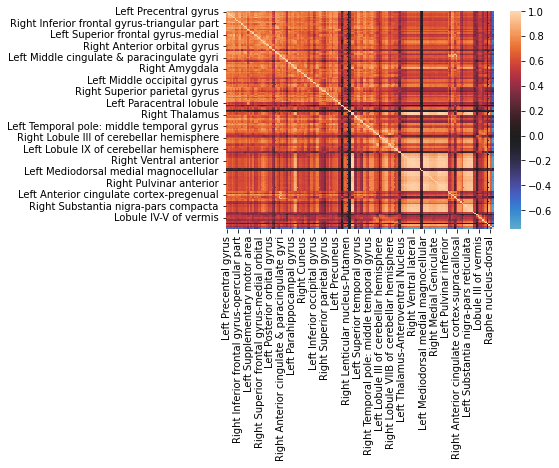

In [12]:
sns.heatmap(x_train.corr(), center=0);

###Model

In [13]:
from sklearn import svm

def svr_model (train_cluster, test_cluster, y_train_cluster, y_test_cluster): 
  cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

  # Construct pipeline
  pipe_svm = Pipeline([
              ('clf', svm.SVR())
  ])
  # Set grid search params
  param_grid_svm = [
    {'clf__C': np.logspace(-3, 3, 10), 'clf__kernel': ['linear']},
    {'clf__C': np.logspace(-3, 3, 10), 'clf__gamma': np.logspace(-10, 0, 20), 'clf__kernel': ['rbf']},
  ]
  # Construct grid search
  gs_svm = GridSearchCV(estimator=pipe_svm,
              param_grid=param_grid_svm,
              scoring='r2',
              cv=cv, verbose=10, n_jobs=-1, return_train_score = True)
  # Fit using grid search
  gs_svm.fit(train_cluster, y_train_cluster)

  # Compute predictions
  predict_train, predict_test = predict(
      gs_svm.best_estimator_,
      train_cluster,
      test_cluster
  )
      
  # Compute MAE and R2 scores
  train_mae, test_mae = compute_mae(y_train_cluster, y_test_cluster, predict_train, predict_test)
  train_r2, test_r2 = compute_r2(y_train_cluster, y_test_cluster, predict_train, predict_test)

  return gs_svm.best_score_, train_r2, test_r2, train_mae, test_mae


In [14]:
from sklearn.linear_model import ElasticNet

def elastic_model (train_cluster, test_cluster, y_train_cluster, y_test_cluster): 
  cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

  # Construct pipeline
  pipe_el = Pipeline([
              ('clf', ElasticNet())
  ])
  # Set grid search params
  elastic_param_grid = {
      'clf__alpha': np.logspace(-10,7,25),
      'clf__l1_ratio': np.append(np.logspace(-10,0,20), 0)
  }

  # Construct grid search
  gs_el = GridSearchCV(estimator=pipe_el,
              param_grid=elastic_param_grid,
              scoring='r2',
              n_jobs=-1,
              cv=cv, verbose=10, return_train_score = True)

  # Fit using grid search
  gs_el.fit(train_cluster, y_train_cluster)

  # Compute predictions
  predict_train, predict_test = predict(
      gs_el.best_estimator_,
      train_cluster,
      test_cluster
  )
      
  # Compute MAE and R2 scores
  train_mae, test_mae = compute_mae(y_train_cluster, y_test_cluster, predict_train, predict_test)
  train_r2, test_r2 = compute_r2(y_train_cluster, y_test_cluster, predict_train, predict_test)

  return gs_el.best_score_, train_r2, test_r2, train_mae, test_mae


In [15]:
from sklearn.ensemble import AdaBoostRegressor

def adaboost_model (train_cluster, test_cluster, y_train_cluster, y_test_cluster):
  cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

  # Construct pipeline
  pipe_ab = Pipeline([
              ('clf', AdaBoostRegressor(random_state = 123))
  ])
  # Set grid search params
  adaboost_param_grid = {
      'clf__n_estimators': np.arange(1, 200, 20),
      'clf__learning_rate': [1.0, 0.5, 0.1]
  }

  # Construct grid search
  gs_ab = GridSearchCV(estimator=pipe_ab,
              param_grid=adaboost_param_grid,
              scoring='r2',
              n_jobs=-1,
              cv=cv, verbose=10, return_train_score = True)

  # Fit using grid search
  gs_ab.fit(train_cluster, y_train_cluster)

  # Compute predictions
  predict_train, predict_test = predict(
      gs_ab.best_estimator_,
      train_cluster,
      test_cluster
  )
      
  # Compute MAE and R2 scores
  train_mae, test_mae = compute_mae(y_train_cluster, y_test_cluster, predict_train, predict_test)
  train_r2, test_r2 = compute_r2(y_train_cluster, y_test_cluster, predict_train, predict_test)

  return gs_ab.best_score_, train_r2, test_r2, train_mae, test_mae


In [16]:
# Long time to run !!


# imports
from sklearn.ensemble import RandomForestRegressor

def random_forest_model (train_cluster, test_cluster, y_train_cluster, y_test_cluster):
  cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

  # Construct pipeline
  pipe_rf = Pipeline([
              ('clf', RandomForestRegressor())
  ])
  # Set grid search params
  param_grid_forest = [ 
    {'clf__n_estimators': np.arange(10, 100, 20),
    'clf__max_depth': np.arange(1, 20)
    }
  ]
  # Construct grid search
  gs_rf = GridSearchCV(estimator=pipe_rf,
              param_grid=param_grid_forest,
              scoring='r2',
              n_jobs=-1,
              cv=cv, verbose=10, return_train_score = True)

  # Fit using grid search
  gs_rf.fit(train_cluster, y_train_cluster)

  # Compute predictions
  predict_train, predict_test = predict(
      gs_rf.best_estimator_,
      train_cluster,
      test_cluster
  )
      
  # Compute MAE and R2 scores
  train_mae, test_mae = compute_mae(y_train_cluster, y_test_cluster, predict_train, predict_test)
  train_r2, test_r2 = compute_r2(y_train_cluster, y_test_cluster, predict_train, predict_test)

  return gs_rf.best_score_, train_r2, test_r2, train_mae, test_mae


In [17]:
# imports
from sklearn.neighbors import KNeighborsRegressor

def knn_model (train_cluster, test_cluster, y_train_cluster, y_test_cluster):
  cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

  # Construct pipeline
  pipe_knn = Pipeline([
              ('clf', KNeighborsRegressor())
  ])
  # Set grid search params
  param_grid_knn = [ 
    {
        'clf__n_neighbors': np.arange(1, 20)
    }
  ]
  # Construct grid search
  gs_knn = GridSearchCV(estimator=pipe_knn,
              param_grid=param_grid_knn,
              scoring='r2',
              n_jobs=-1,
              cv=cv, verbose=10, return_train_score = True)

  # Fit using grid search
  gs_knn.fit(train_cluster, y_train_cluster)

  # Compute predictions
  predict_train, predict_test = predict(
      gs_knn.best_estimator_,
      train_cluster,
      test_cluster
  )
      
  # Compute MAE and R2 scores
  train_mae, test_mae = compute_mae(y_train_cluster, y_test_cluster, predict_train, predict_test)
  train_r2, test_r2 = compute_r2(y_train_cluster, y_test_cluster, predict_train, predict_test)

  return gs_knn.best_score_, train_r2, test_r2, train_mae, test_mae

# PLS

In [18]:
from sklearn.cross_decomposition import PLSRegression

In [19]:
# PLS Regression
n_components = 20
pls = PLSRegression(n_components=n_components)
pls.fit(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'), y_train)

new_x_train = pls.transform(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
new_x_test = pls.transform(x_test.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pls_train = pd.DataFrame(data = new_x_train, columns = ["class%02d" %i for i in range(1,n_components+1)])
pls_test = pd.DataFrame(data = new_x_test, columns = ["class%02d" %i for i in range(1,n_components+1)])

### Standardize

In [20]:
train_mean = np.mean(pls_train, axis=0)
train_std = np.std(pls_test, axis=0)

pls_train_scaled = (pls_train - train_mean)/train_std
pls_test_scaled = (pls_test - train_mean)/train_std

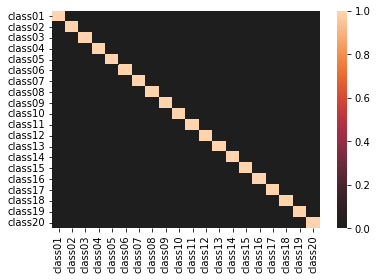

In [21]:
sns.heatmap(pd.DataFrame(pls_train_scaled).corr(), center=0);

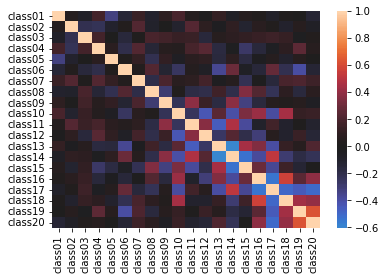

In [22]:
sns.heatmap(pd.DataFrame(pls_test_scaled).corr(), center=0);

### Clustering

In [23]:
kmeanModel = KMeans(n_clusters=3).fit(pls_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

pls_train_scaled['Cluster'] = kmeanModel.labels_
pls_test_scaled['Cluster'] = kmeanModel.predict(pls_test_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

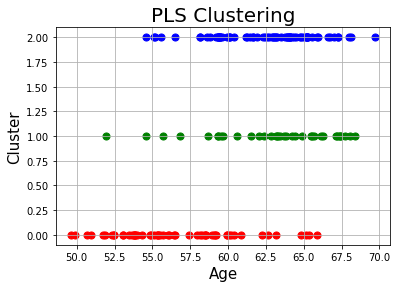

In [24]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Age', fontsize = 15)
ax.set_ylabel('Cluster', fontsize = 15)
ax.set_title('PLS Clustering', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    idx = (pls_train_scaled['Cluster'] == target).to_numpy()
    ax.scatter(y_train[idx],
            np.full(y_train[idx].shape, target),
               c = color, 
               s = 50)
ax.grid()

### Filter MI Score

In [25]:
mi_score_train = make_mi_scores(pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

keep_pls = (mi_score_train[mi_score_train > 0].index.to_list())

keep_pls.append('Cluster')

pls_train_scaled = pls_train_scaled[keep_pls]
pls_test_scaled = pls_test_scaled[keep_pls]

### Test for each cluster

In [26]:
#Init DataFrame for Cluster 0
cluster_tr = pls_train_scaled.iloc[np.where(pls_train_scaled["Cluster"]==0)]
train_cluster = cluster_tr.drop(['Cluster'], axis=1, errors='ignore')
y_train_cluster = y_train.iloc[np.where(pls_train_scaled["Cluster"]==0)]

cluster_te = pls_test_scaled.iloc[np.where(pls_test_scaled["Cluster"]==0)]
test_cluster = cluster_te.drop(['Cluster'], axis=1, errors='ignore')
y_test_cluster = y_test.iloc[np.where(pls_test_scaled["Cluster"]==0)]

#Create DataFrame for the result
df_pls_0 = pd.DataFrame(columns=["Best score", "Train r2",  "Test r2", "Train mae", "Test mae"])


#Test for each model
df_pls_0.loc["SVR"] = svr_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_0.loc["Elastic Net"] = elastic_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_0.loc["Adaboost"] = adaboost_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_0.loc["Random Forest"] = random_forest_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_0.loc["KNN"] = knn_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_0

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.967e+01, tolerance: 8.975e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


,Best score,Train r2,Test r2,Train mae,Test mae
SVR,0.495670,0.981668,-0.087882,0.268911,4.107001
Elastic Net,0.575903,0.805604,-0.319026,1.495988,4.916170
Adaboost,0.227057,0.926393,-0.276205,0.933817,4.474892
Random Forest,0.231613,0.879635,-0.305741,1.116627,4.575055
KNN,0.259000,0.574923,-0.314684,2.160242,4.649970


In [27]:
#Init DataFrame for Cluster 1
cluster_tr = pls_train_scaled.iloc[np.where(pls_train_scaled["Cluster"]==1)]
train_cluster = cluster_tr.drop(['Cluster'], axis=1, errors='ignore')
y_train_cluster = y_train.iloc[np.where(pls_train_scaled["Cluster"]==1)]

cluster_te = pls_test_scaled.iloc[np.where(pls_test_scaled["Cluster"]==1)]
test_cluster = cluster_te.drop(['Cluster'], axis=1, errors='ignore')
y_test_cluster = y_test.iloc[np.where(pls_test_scaled["Cluster"]==1)]

#Create DataFrame for the result
df_pls_1 = pd.DataFrame(columns=["Best score", "Train r2",  "Test r2", "Train mae", "Test mae"])


#Test for each model
df_pls_1.loc["SVR"] = svr_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_1.loc["Elastic Net"] = elastic_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_1.loc["Adaboost"] = adaboost_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_1.loc["Random Forest"] = random_forest_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_1.loc["KNN"] = knn_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_1

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.179e+01, tolerance: 5.823e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


,Best score,Train r2,Test r2,Train mae,Test mae
SVR,0.424302,0.781374,-0.369538,1.260788,4.632630
Elastic Net,0.404520,0.817371,-0.441615,1.368798,4.911734
Adaboost,0.053905,0.959318,-0.097932,0.688355,3.952470
Random Forest,0.088634,0.888750,-0.215704,1.081790,4.287989
KNN,0.274236,0.572840,-0.561417,2.151627,5.153121


In [28]:
#Init DataFrame for Cluster 2
cluster_tr = pls_train_scaled.iloc[np.where(pls_train_scaled["Cluster"]==2)]
train_cluster = cluster_tr.drop(['Cluster'], axis=1, errors='ignore')
y_train_cluster = y_train.iloc[np.where(pls_train_scaled["Cluster"]==2)]

cluster_te = pls_test_scaled.iloc[np.where(pls_test_scaled["Cluster"]==2)]
test_cluster = cluster_te.drop(['Cluster'], axis=1, errors='ignore')
y_test_cluster = y_test.iloc[np.where(pls_test_scaled["Cluster"]==2)]

#Create DataFrame for the result
df_pls_2 = pd.DataFrame(columns=["Best score", "Train r2",  "Test r2", "Train mae", "Test mae"])


#Test for each model
df_pls_2.loc["SVR"] = svr_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_2.loc["Elastic Net"] = elastic_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_2.loc["Adaboost"] = adaboost_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_2.loc["Random Forest"] = random_forest_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_2.loc["KNN"] = knn_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pls_2

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e+02, tolerance: 7.820e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


,Best score,Train r2,Test r2,Train mae,Test mae
SVR,0.510381,0.815217,0.009594,0.952818,3.781548
Elastic Net,0.576836,0.757335,0.010223,1.343220,3.726502
Adaboost,0.282045,0.895255,-0.004390,0.977932,3.875161
Random Forest,0.269408,0.869173,0.130637,0.972898,3.697294
KNN,0.188916,0.429992,0.108735,1.993385,3.700644


# PCA

In [29]:
from sklearn.decomposition import PCA

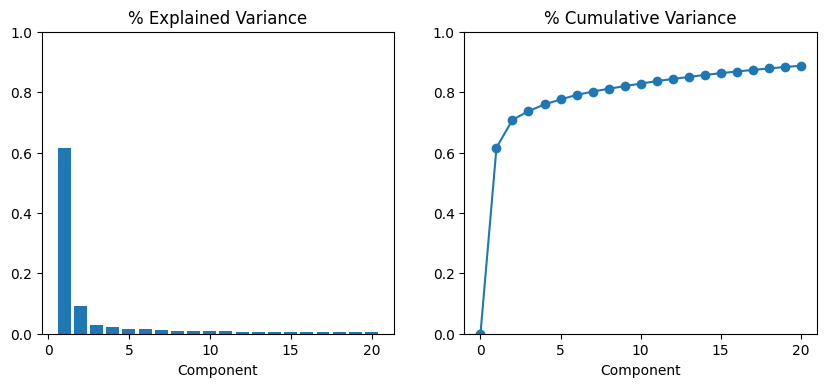

In [30]:
pca = PCA(n_components=20)
pc = pca.fit_transform(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pc_train = pd.DataFrame(data = pc, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])
pc_test = pca.transform(x_test.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pc_test = pd.DataFrame(data = pc_test, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])

# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title=f"% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(
    xlabel="Component", title=f"% Cumulative Variance", ylim=(0.0, 1.0)
)

# Set up figure
fig.set(figwidth=10, dpi=100)
fig.show()

### Standardize

In [31]:
train_mean = np.mean(pc_train, axis=0)
train_std = np.std(pc_train, axis=0)

pc_train_scaled = (pc_train - train_mean)/train_std
pc_test_scaled = (pc_test - train_mean)/train_std

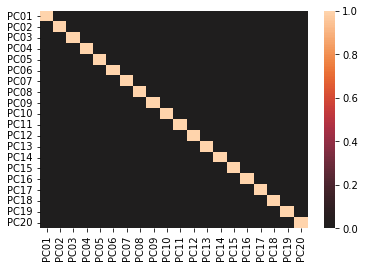

In [32]:
sns.heatmap(pd.DataFrame(pc_train_scaled).corr(), center=0);

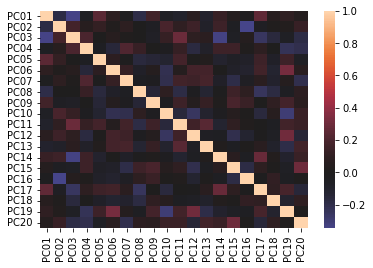

In [33]:
sns.heatmap(pd.DataFrame(pc_test_scaled).corr(), center=0);

### Clustering

In [34]:
kmeanModel = KMeans(n_clusters=3).fit(pc_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

pc_train_scaled['Cluster'] = kmeanModel.labels_
pc_test_scaled['Cluster'] = kmeanModel.predict(pc_test_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

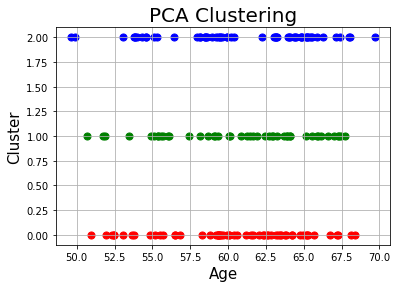

In [35]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Age', fontsize = 15)
ax.set_ylabel('Cluster', fontsize = 15)
ax.set_title('PCA Clustering', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    idx = (pc_train_scaled['Cluster'] == target).to_numpy()
    ax.scatter(y_train[idx],
            np.full(y_train[idx].shape, target),
               c = color, 
               s = 50)
ax.grid()

### Filter MI Score

After testing, keeping only PC with MI Score > 0 didn't improve the results (slightly worse in fact)

### Test Model for each cluster

In [37]:
#Init DataFrame for Cluster 0
cluster_tr = pc_train_scaled.iloc[np.where(pc_train_scaled["Cluster"]==0)]
train_cluster = cluster_tr.drop(['Cluster'], axis=1, errors='ignore')
y_train_cluster = y_train.iloc[np.where(pc_train_scaled["Cluster"]==0)]

cluster_te = pc_test_scaled.iloc[np.where(pc_test_scaled["Cluster"]==0)]
test_cluster = cluster_te.drop(['Cluster'], axis=1, errors='ignore')
y_test_cluster = y_test.iloc[np.where(pc_test_scaled["Cluster"]==0)]

#Create DataFrame for the result
df_pca_0 = pd.DataFrame(columns=["Best score", "Train r2",  "Test r2", "Train mae", "Test mae"])


#Test for each model
df_pca_0.loc["SVR"] = svr_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0.loc["Elastic Net"] = elastic_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0.loc["Adaboost"] = adaboost_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0.loc["Random Forest"] = random_forest_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0.loc["KNN"] = knn_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.383e+02, tolerance: 1.170e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


,Best score,Train r2,Test r2,Train mae,Test mae
SVR,-0.084257,0.318759,0.055174,2.711122,4.535132
Elastic Net,-0.060736,0.140415,0.027369,3.413742,4.633306
Adaboost,-0.164552,0.921179,-0.072991,1.069634,4.667787
Random Forest,-0.099347,0.855585,-0.006636,1.376764,4.760219
KNN,-0.080469,0.080718,0.039617,3.453347,4.601899


In [38]:
#Init DataFrame for Cluster 1
cluster_tr = pc_train_scaled.iloc[np.where(pc_train_scaled["Cluster"]==1)]
train_cluster = cluster_tr.drop(['Cluster'], axis=1, errors='ignore')
y_train_cluster = y_train.iloc[np.where(pc_train_scaled["Cluster"]==1)]

cluster_te = pc_test_scaled.iloc[np.where(pc_test_scaled["Cluster"]==1)]
test_cluster = cluster_te.drop(['Cluster'], axis=1, errors='ignore')
y_test_cluster = y_test.iloc[np.where(pc_test_scaled["Cluster"]==1)]

#Create DataFrame for the result
df_pca_1 = pd.DataFrame(columns=["Best score", "Train r2",  "Test r2", "Train mae", "Test mae"])


#Test for each model
df_pca_1.loc["SVR"] = svr_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1.loc["Elastic Net"] = elastic_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1.loc["Adaboost"] = adaboost_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1.loc["Random Forest"] = random_forest_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1.loc["KNN"] = knn_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


,Best score,Train r2,Test r2,Train mae,Test mae
SVR,0.002757,0.360613,0.083455,2.798699,4.055285
Elastic Net,-0.011404,0.159324,0.068628,3.643466,4.130700
Adaboost,-0.179807,0.770361,-0.255385,1.686855,4.822327
Random Forest,-0.133868,0.287219,0.023696,3.274459,4.209646
KNN,-0.051071,0.083906,0.070642,3.795742,4.166958


In [39]:
#Init DataFrame for Cluster 2
cluster_tr = pc_train_scaled.iloc[np.where(pc_train_scaled["Cluster"]==2)]
train_cluster = cluster_tr.drop(['Cluster'], axis=1, errors='ignore')
y_train_cluster = y_train.iloc[np.where(pc_train_scaled["Cluster"]==2)]

cluster_te = pc_test_scaled.iloc[np.where(pc_test_scaled["Cluster"]==2)]
test_cluster = cluster_te.drop(['Cluster'], axis=1, errors='ignore')
y_test_cluster = y_test.iloc[np.where(pc_test_scaled["Cluster"]==2)]

#Create DataFrame for the result
df_pca_2 = pd.DataFrame(columns=["Best score", "Train r2",  "Test r2", "Train mae", "Test mae"])


#Test for each model
df_pca_2.loc["SVR"] = svr_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2.loc["Elastic Net"] = elastic_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2.loc["Adaboost"] = adaboost_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2.loc["Random Forest"] = random_forest_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2.loc["KNN"] = knn_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.101e+02, tolerance: 1.351e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


,Best score,Train r2,Test r2,Train mae,Test mae
SVR,-0.086209,0.350637,0.129640,2.854333,3.840499
Elastic Net,-0.064390,0.170844,0.102792,3.736782,4.001607
Adaboost,-0.120337,0.903124,0.195234,1.296423,3.782042
Random Forest,-0.109717,0.853346,0.009246,1.481932,4.246928
KNN,-0.076955,0.102283,0.205165,3.883897,3.731508
